# Прогнозирование уровня средней заработной платы в России

In [2]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


/home/maxim/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## 1. Визуальный анализ

Импорт данных о среднемесячных уровнях заработной платы в России за каждый месяц с января 1993 по август 2016

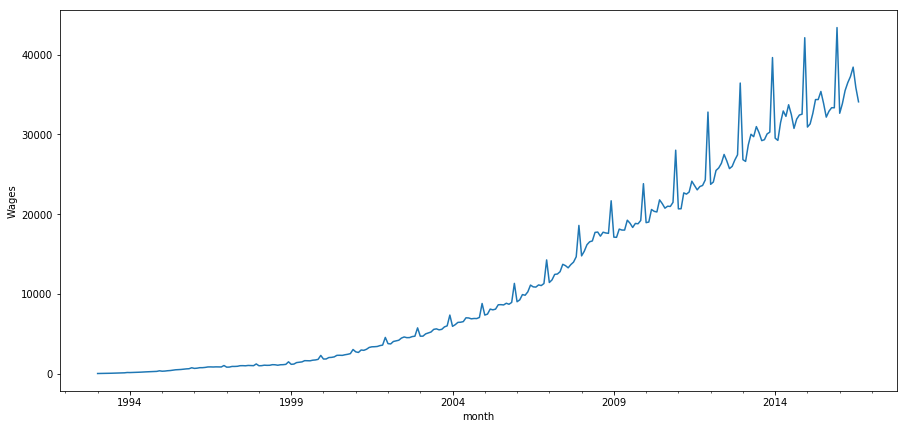

In [4]:
data = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
plt.ylabel('Wages')
pylab.show()

In [29]:
data.WAG_C_M

month
1993-01-01       15.3
1993-02-01       19.1
1993-03-01       23.6
1993-04-01       30.6
1993-05-01       37.5
1993-06-01       47.4
1993-07-01       56.0
1993-08-01       65.4
1993-09-01       80.9
1993-10-01       93.0
1993-11-01      101.5
1993-12-01      141.2
1994-01-01      134.2
1994-02-01      144.7
1994-03-01      164.8
1994-04-01      171.5
1994-05-01      183.5
1994-06-01      207.5
1994-07-01      221.0
1994-08-01      232.8
1994-09-01      253.2
1994-10-01      265.0
1994-11-01      281.6
1994-12-01      354.2
1995-01-01      302.6
1995-02-01      321.0
1995-03-01      361.5
1995-04-01      386.2
1995-05-01      429.9
1995-06-01      480.6
               ...   
2014-03-01    31486.0
2014-04-01    32947.0
2014-05-01    32272.0
2014-06-01    33726.0
2014-07-01    32515.0
2014-08-01    30763.0
2014-09-01    31929.0
2014-10-01    32439.0
2014-11-01    32546.0
2014-12-01    42136.0
2015-01-01    30929.0
2015-02-01    31325.0
2015-03-01    32642.0
2015-04-01    34377.0
2015

Из визуального анализа можно сделать вывод о наличии повышающегося тренда, ярковыраженной сезонности и нестационарной дисперсии изучаемого временного ряда. Проверим стационарность формально с помощью критерия Дики-Фуллера и заодно посмотрим на результаты STL-декампозиции

Критерий Дики-Фуллера: p=0.991850


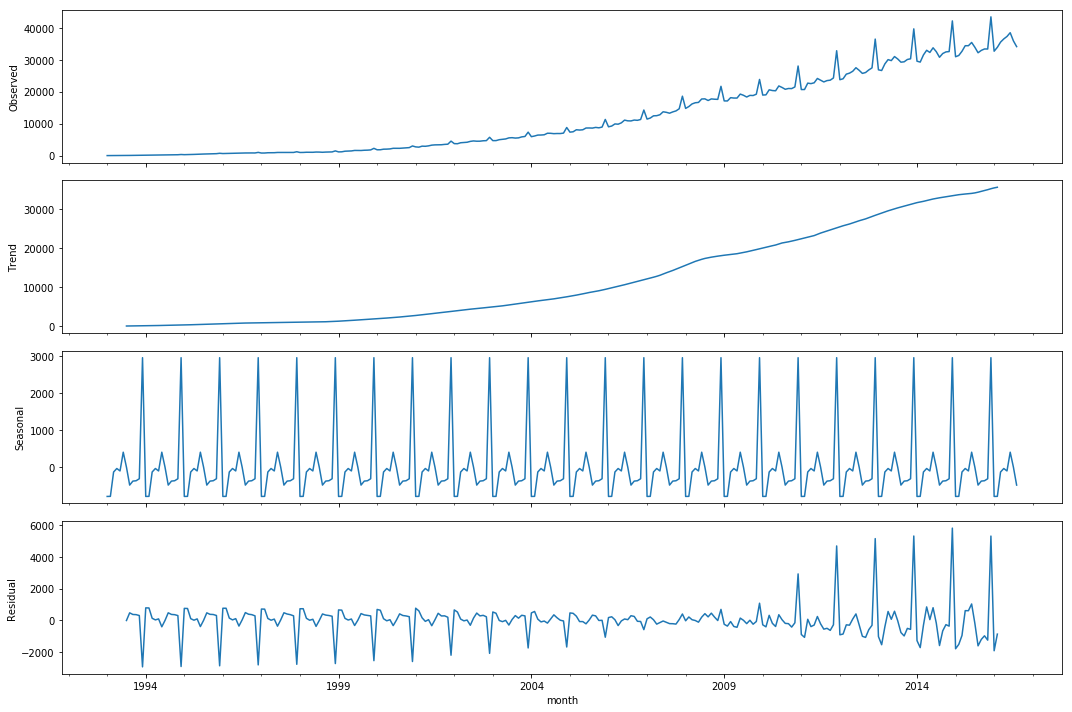

In [5]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

Критерий Дики-Фуллера не позволяет отклонить гипотеху о нестационарности ряда. STL-декомпозиция подтверждает наличие тренда, сезонные колебания, а график остатков - нестационарную дисперцию исходного ряда

## 2. Стабилизация дисперсии

Стабилизирцем дисперсию временного ряда с помощью преобразования Бокса-Кокса

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


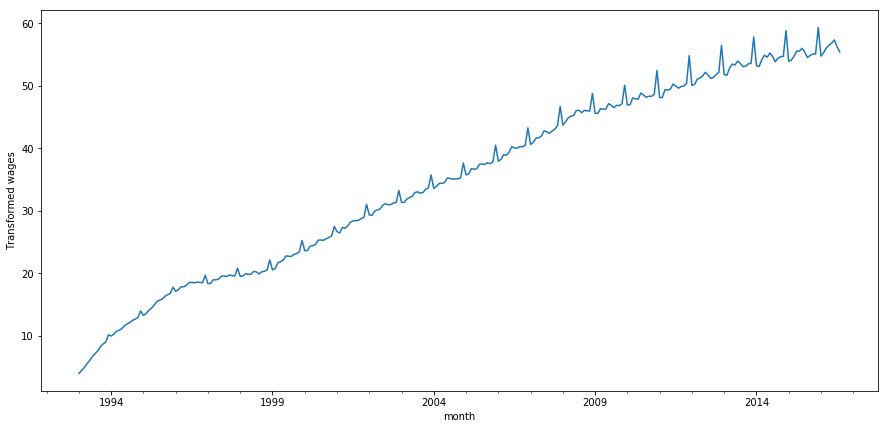

In [6]:
data['wag_box'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(15,7))
data.wag_box.plot()
plt.ylabel(u'Transformed wages')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wag_box)[1])

Чисто визуально, дисперсия ряда явно более стабильная, однако ряд по-прежнему не является стационарным.

## 3. Выбор порядка дифференцирования

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но в данных очевидно присутствует тренд и сезонность. Применим сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность

Критерий Дики-Фуллера: p=0.014697


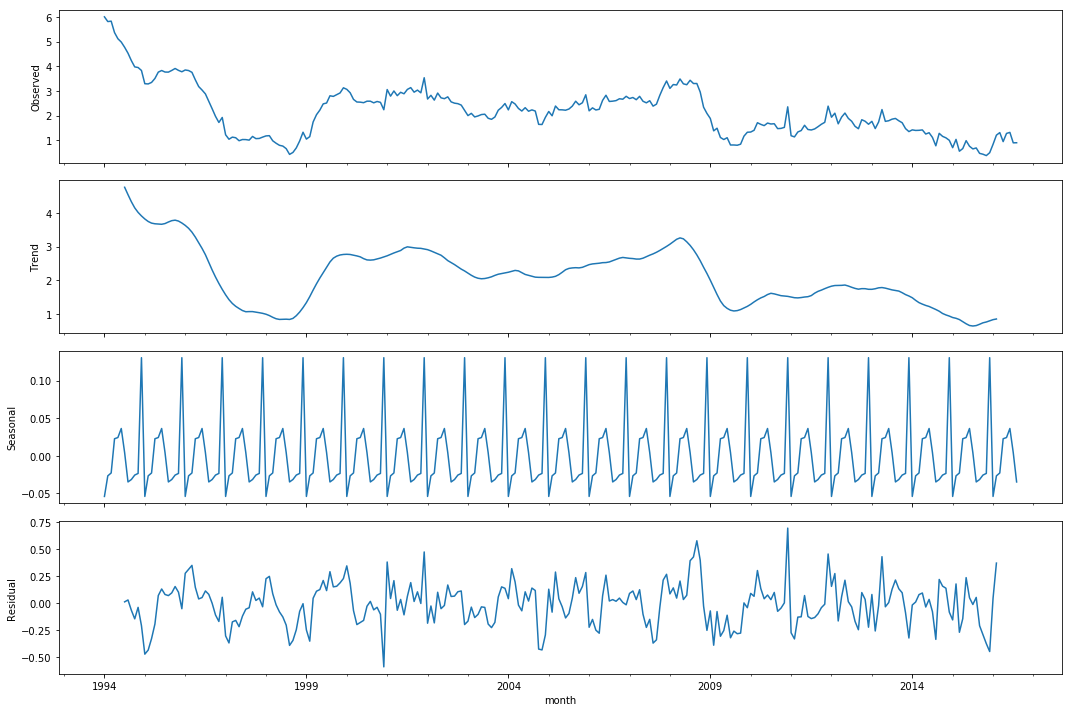

In [7]:
data['wag_box_diff'] = data.wag_box - data.wag_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wag_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wag_box_diff[12:])[1])

Достигаемый уровень значимости критерия Дики-Фуллера позволяет отвергнуть нулевую гипотезу о нестационарности ряда на 95% уроне значимости в пользу альтернативы (ряд стационарен). Поэтому дальнейшее дифференцирование ряда производить не будем

## 4. Выбор начальных приближений для p,q,P,Q

Посмотрим на ACF и PACF полученного ряда

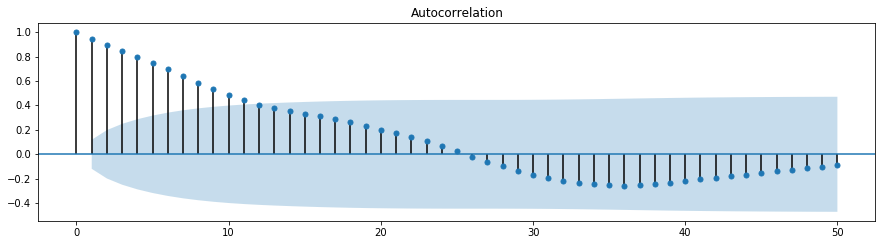

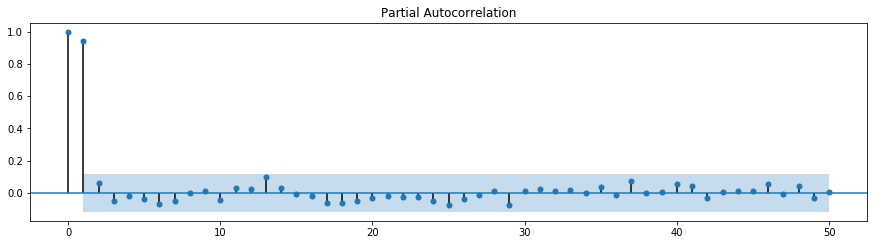

In [16]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.wag_box_diff[12:].values.squeeze(), lags=50, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.wag_box_diff[12:].values.squeeze(), lags=50, ax=ax)
pylab.show()

<b>При подборе Q:</b> столбик, соответствующий лагу в 12 месяцев находится на границе области значимости. Так как мы все равно будем перебирать варианты модели, будем считать, что этот столбик значим, т. е. примем начальное приближение Q=1<br>
<b>Начальные приближения:</b> Q=1, q=11, P=0, p=1

In [21]:
ps = range(0, 2)
d=0
qs = range(0, 12)
P = 0
D=1
Qs = range(0, 2)

In [22]:
parameters = product(ps, qs, Qs)
parameters_list = list(parameters)
len(parameters_list)

48

In [23]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.wag_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(P, D, param[2], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0))
('wrong parameters:', (0, 0, 1))
('wrong parameters:', (0, 1, 1))
('wrong parameters:', (0, 2, 1))
('wrong parameters:', (0, 3, 0))
('wrong parameters:', (0, 3, 1))
('wrong parameters:', (0, 4, 0))
('wrong parameters:', (0, 4, 1))
('wrong parameters:', (0, 5, 0))
('wrong parameters:', (0, 5, 1))
('wrong parameters:', (0, 6, 0))
('wrong parameters:', (0, 6, 1))
('wrong parameters:', (0, 7, 0))
('wrong parameters:', (0, 7, 1))
('wrong parameters:', (0, 8, 0))
('wrong parameters:', (0, 8, 1))
('wrong parameters:', (0, 9, 0))
('wrong parameters:', (0, 9, 1))
('wrong parameters:', (0, 10, 0))
('wrong parameters:', (0, 10, 1))
('wrong parameters:', (0, 11, 0))
('wrong parameters:', (0, 11, 1))
('wrong parameters:', (1, 0, 1))
('wrong parameters:', (1, 1, 1))
('wrong parameters:', (1, 2, 1))
('wrong parameters:', (1, 3, 1))
('wrong parameters:', (1, 4, 1))
('wrong parameters:', (1, 5, 1))
('wrong parameters:', (1, 6, 1))
('wrong parameters:', (1, 7, 1))
('wron

In [24]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

    parameters       aic
11   (1, 9, 0) -7.880969
12  (1, 10, 0) -6.582790
13  (1, 11, 0) -5.127191
10   (1, 8, 0) -4.342946
9    (1, 7, 0) -2.680371


In [25]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            wag_box   No. Observations:                  284
Model:             SARIMAX(1, 0, 9)x(0, 1, 0, 12)   Log Likelihood                  14.940
Date:                            Mon, 02 Apr 2018   AIC                             -7.881
Time:                                    23:21:34   BIC                             32.258
Sample:                                01-01-1993   HQIC                             8.211
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9894      0.007    139.879      0.000       0.976       1.003
ma.L1         -0.1913      0.049   

## 6.Анализ остатков построенной модели

Критерий Стьюдента: p=0.392795
Критерий Дики-Фуллера: p=0.000000


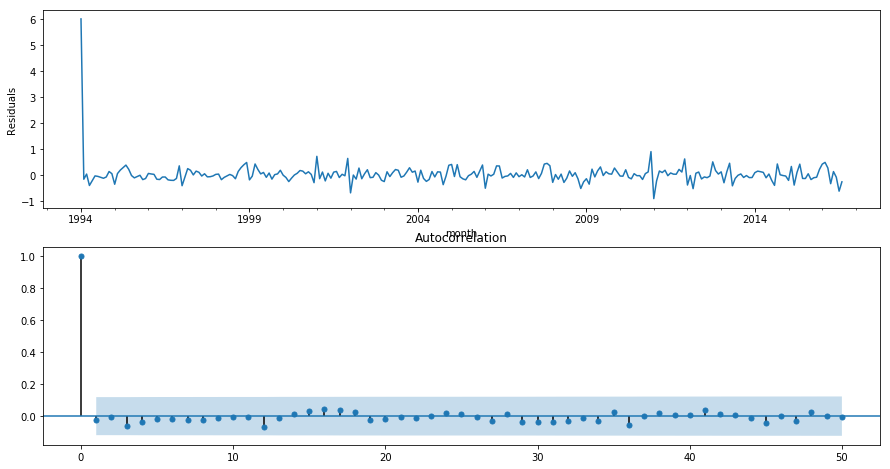

In [26]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[12:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[12:].values.squeeze(), lags=50, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[12:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[12:])[1])

Таким образом, остатки обладают свойситвами:
1. Несмещенности (подтверждается критерием Стьюдента) 
2. Стационарности (подтверждается критерием Дики-Фуллера и визуально)
3. Неавтокоррелированностью (подтверждается критерием Льюнга-Бокса и коррелограммой). 

## 7.Прогнозирование с помощью финальной модели

Сначала оценим визуально, насколько близки модельные значения к наблюдаемым

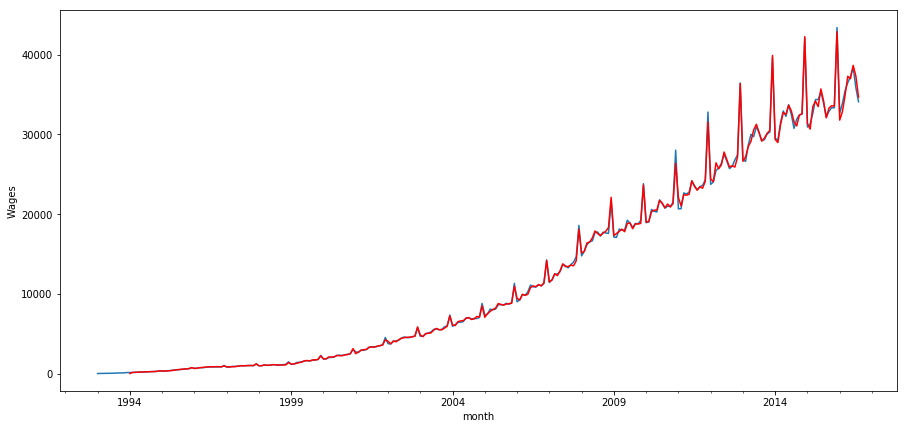

In [28]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[12:].plot(color='r')
plt.ylabel('Wages')
pylab.show()

Построим прогноз с использованием модели

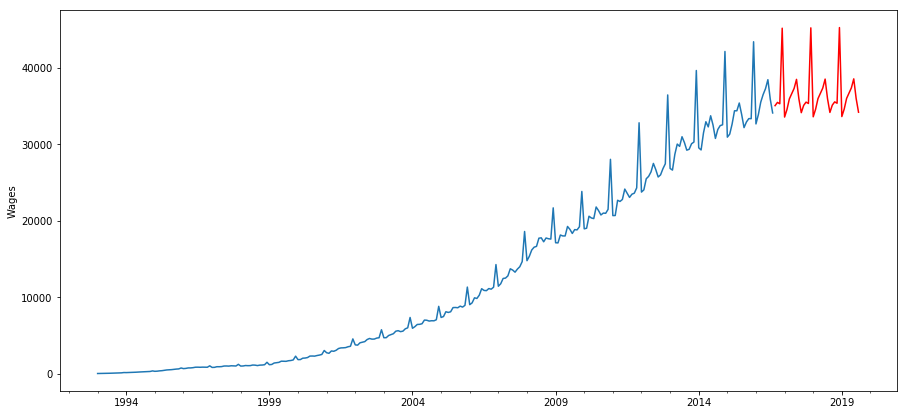

In [31]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=284, end=320), lmbda)

plt.figure(figsize(15,7))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel('Wages')
pylab.show()